In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

# Configuration
DATA_PATH = 'CMAPSSData/'  
DATASET_NUM = 1            
MODEL_TYPE = 'lstm'        # 'lstm' or 'gru'
TRAIN_PERCENT = 0.85       # Percentage of initial cycles for training
SEQUENCE_LENGTH = 10       
THRESHOLD_MULTIPLIER = 2.5 # Multiplier for threshold (μ + nσ)

Epoch 1/100
93/93 [==============================] - 6s 24ms/step - loss: 0.0815 - val_loss: 0.0255
Epoch 2/100
93/93 [==============================] - 1s 13ms/step - loss: 0.0183 - val_loss: 0.0142
Epoch 3/100
93/93 [==============================] - 1s 13ms/step - loss: 0.0125 - val_loss: 0.0117
Epoch 4/100
93/93 [==============================] - 1s 13ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 5/100
93/93 [==============================] - 1s 13ms/step - loss: 0.0108 - val_loss: 0.0109
Epoch 6/100
93/93 [==============================] - 1s 13ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 7/100
93/93 [==============================] - 1s 14ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 8/100
93/93 [==============================] - 1s 14ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 9/100
93/93 [==============================] - 1s 14ms/step - loss: 0.0107 - val_loss: 0.0109
Epoch 10/100
93/93 [==============================] - 1s 14ms/step - loss: 0.0107 - val_loss: 0.0109

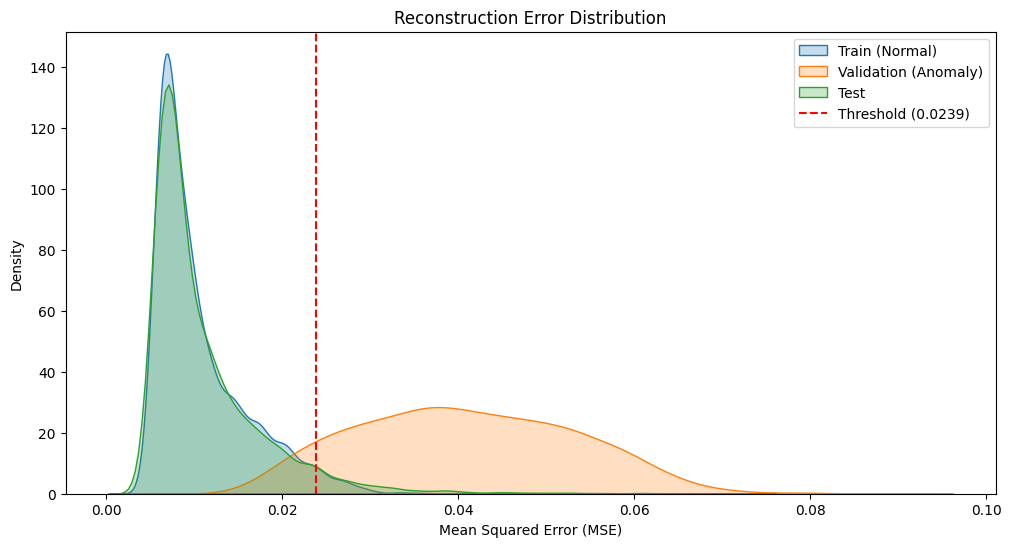


Top 5 engines with most anomalies in test:
Engine 65: 62.90%
Engine 78: 53.97%
Engine 52: 27.22%
Engine 101: 23.81%
Engine 54: 20.54%


In [ ]:
# Load data
def load_data(dataset_num=1):
    """Loads CMAPSS training and test data"""
    def process_data(file):
        data = pd.read_csv(file, sep=' ', header=None)
        data.drop(data.columns[[26, 27]], axis=1, inplace=True)
        data.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]
        return data
    
    train = process_data(f'{DATA_PATH}train_FD00{dataset_num}.txt')
    test = process_data(f'{DATA_PATH}test_FD00{dataset_num}.txt')
    rul = pd.read_csv(f'{DATA_PATH}RUL_FD00{dataset_num}.txt', sep=' ', header=None, names=['rul'])

    return train, test, rul

# Preprocessing
def preprocess_data(train, test, rul):
    """Preprocesses data for the model"""
    # Normalization
    scaler = MinMaxScaler()
    sensor_cols = [f'sensor{i}' for i in range(1, 22)]
    settings_cols = ['setting1', 'setting2', 'setting3']
    
    # Data scaling
    train_scaled = train.copy()
    train_scaled[sensor_cols + settings_cols] = scaler.fit_transform(train_scaled[sensor_cols + settings_cols])
    test_scaled = test.copy()
    test_scaled[sensor_cols + settings_cols] = scaler.transform(test_scaled[sensor_cols + settings_cols])
    
    # Separate normal data (first cycles) and anomalous data (last cycles)
    train_ids = train_scaled['id'].unique()
    normal_data = []
    anomaly_data = []
    
    for engine_id in train_ids:
        engine_data = train_scaled[train_scaled['id'] == engine_id]
        split_idx = int(len(engine_data) * TRAIN_PERCENT)
        normal_data.append(engine_data[:split_idx])
        anomaly_data.append(engine_data[split_idx:])
    
    return pd.concat(normal_data), pd.concat(anomaly_data), test_scaled, scaler

# Prepare sequences for LSTM/GRU
def create_sequences(data, sequence_length=SEQUENCE_LENGTH):
    """Creates temporal sequences for the model"""
    features = [f'sensor{i}' for i in range(1, 22)] + ['setting1', 'setting2', 'setting3']
    sequences = []
    engine_ids = data['id'].unique()
    
    for engine_id in engine_ids:
        engine_data = data[data['id'] == engine_id]
        engine_values = engine_data[features].values
        for i in range(len(engine_values) - sequence_length + 1):
            sequences.append(engine_values[i:i + sequence_length])
    
    return np.array(sequences)

# Autoencoder Model
def build_model(input_shape, model_type=MODEL_TYPE):
    """Builds the autoencoder model"""
    model = Sequential()
    
    # Encoder
    if model_type == 'lstm':
        model.add(LSTM(16, activation='tanh', input_shape=input_shape, return_sequences=True))
        model.add(LSTM(8, activation='tanh', return_sequences=False))
    else:  # gru
        model.add(GRU(16, activation='tanh', input_shape=input_shape, return_sequences=True))
        model.add(GRU(8, activation='tanh', return_sequences=False))
    
    model.add(RepeatVector(input_shape[0]))
    
    # Decoder
    if model_type == 'lstm':
        model.add(LSTM(8, activation='tanh', return_sequences=True))
        model.add(LSTM(16, activation='tanh', return_sequences=True))
    else:  # gru
        model.add(GRU(8, activation='tanh', return_sequences=True))
        model.add(GRU(16, activation='tanh', return_sequences=True))
    
    model.add(TimeDistributed(Dense(input_shape[1])))
    model.compile(optimizer='adam', loss='mse')
    return model

# Anomaly detection with consistent threshold
def detect_anomalies(model, data, threshold=None):
    """
    Detects anomalies using a predefined threshold
    Args:
        model: Trained model
        data: Data to evaluate
        threshold: Precalculated threshold (if None, calculated with THRESHOLD_MULTIPLIER)
    """
    predictions = model.predict(data, verbose=0)
    mse = np.mean(np.power(data - predictions, 2), axis=(1, 2))
    
    if threshold is None:
        threshold = np.mean(mse) + THRESHOLD_MULTIPLIER * np.std(mse)
    
    anomalies = mse > threshold
    return anomalies, mse, threshold

# Results visualization
def plot_results(train_mse, val_mse, test_mse, threshold):
    """Visualizes error distributions and threshold"""
    plt.figure(figsize=(12, 6))
    sns.kdeplot(train_mse, label='Train (Normal)', fill=True)
    sns.kdeplot(val_mse, label='Validation (Anomaly)', fill=True)
    sns.kdeplot(test_mse, label='Test', fill=True)
    plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.4f})')
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Mean Squared Error (MSE)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Main workflow
# Load and prepare data
train, test, rul = load_data(DATASET_NUM)
normal_data, anomaly_data, test_data, scaler = preprocess_data(train, test, rul)

# Create sequences
X_train = create_sequences(normal_data)
X_val = create_sequences(anomaly_data)
X_test = create_sequences(test_data)

# Build and train model
input_shape = (SEQUENCE_LENGTH, X_train.shape[2])
model = build_model(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, X_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Calculate threshold ONLY with normal training data
_, _, threshold = detect_anomalies(model, X_train)
print(f"\nCalculated anomaly threshold: {threshold:.4f}")

# Evaluate all sets with the SAME threshold
_, train_mse, _ = detect_anomalies(model, X_train, threshold=threshold)
_, val_mse, _ = detect_anomalies(model, X_val, threshold=threshold)
test_anomalies, test_mse, _ = detect_anomalies(model, X_test, threshold=threshold)

# Metrics
val_anomaly_rate = np.mean(val_mse > threshold)
test_anomaly_rate = np.mean(test_mse > threshold)

print(f"\nDetection in validation (expected anomalies): {val_anomaly_rate:.2%}")
print(f"Detection in test: {test_anomaly_rate:.2%}")

# Visualization
plot_results(train_mse, val_mse, test_mse, threshold)

# Analysis by engine in test
test_sequences_per_engine = {}
engine_ids = test_data['id'].unique()

for engine_id in engine_ids:
    engine_data = test_data[test_data['id'] == engine_id]
    test_sequences_per_engine[engine_id] = len(engine_data) - SEQUENCE_LENGTH + 1

anomaly_rates = {}
start_idx = 0
for engine_id, num_seq in test_sequences_per_engine.items():
    end_idx = start_idx + num_seq
    anomaly_rates[engine_id] = np.mean(test_anomalies[start_idx:end_idx])
    start_idx = end_idx

print("\nTop 5 engines with most anomalies in test:")
for engine_id, rate in sorted(anomaly_rates.items(), key=lambda x: -x[1])[:5]:
    print(f"Engine {engine_id}: {rate:.2%}")


In [10]:
def plot_engine_timeseries(engine_id, data, model, threshold, sequence_length=SEQUENCE_LENGTH):
    """
    Visualizes reconstruction error over time for a specific engine
    along with the anomaly threshold.
    
    Args:
        engine_id: ID of the engine to visualize
        data: Complete DataFrame with engine data
        model: Trained model
        threshold: Anomaly threshold
        sequence_length: Length of sequences
    """
    # Extract data for specific engine
    engine_data = data[data['id'] == engine_id].copy()
    features = [f'sensor{i}' for i in range(1, 22)] + ['setting1', 'setting2', 'setting3']
    
    # Create sequences for this engine
    sequences = []
    engine_values = engine_data[features].values
    for i in range(len(engine_values) - sequence_length + 1):
        sequences.append(engine_values[i:i + sequence_length])
    sequences = np.array(sequences)
    
    # Calculate errors
    if len(sequences) > 0:
        predictions = model.predict(sequences, verbose=0)
        
        # Ensure dimensions match
        if predictions.shape[1] != sequence_length:
            print(f"Warning: Model returns sequences of length {predictions.shape[1]}, but expected {sequence_length}")
            print("Adjusting error calculation...")
            
            # Calculate MSE only for matching time steps
            min_length = min(predictions.shape[1], sequence_length)
            mse = np.mean(np.power(sequences[:, :min_length, :] - predictions[:, :min_length, :], 2), axis=(1, 2))
        else:
            mse = np.mean(np.power(sequences - predictions, 2), axis=(1, 2))
        
        # Prepare time axis (using final cycle of each sequence)
        cycles = engine_data['cycle'].values[sequence_length-1:]
        
        plt.figure(figsize=(14, 6))
        plt.plot(cycles, mse, 'b-', label='Reconstruction error')
        plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly threshold')
        
        # Mark anomalies
        anomalies = mse > threshold
        if any(anomalies):
            plt.scatter(cycles[anomalies], mse[anomalies], color='red', label='Detected anomalies')
        
        plt.title(f'Reconstruction Error by Cycle - Engine {engine_id}')
        plt.xlabel('Cycle')
        plt.ylabel('Mean Squared Error (MSE)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"Engine {engine_id} does not have enough data to create sequences")

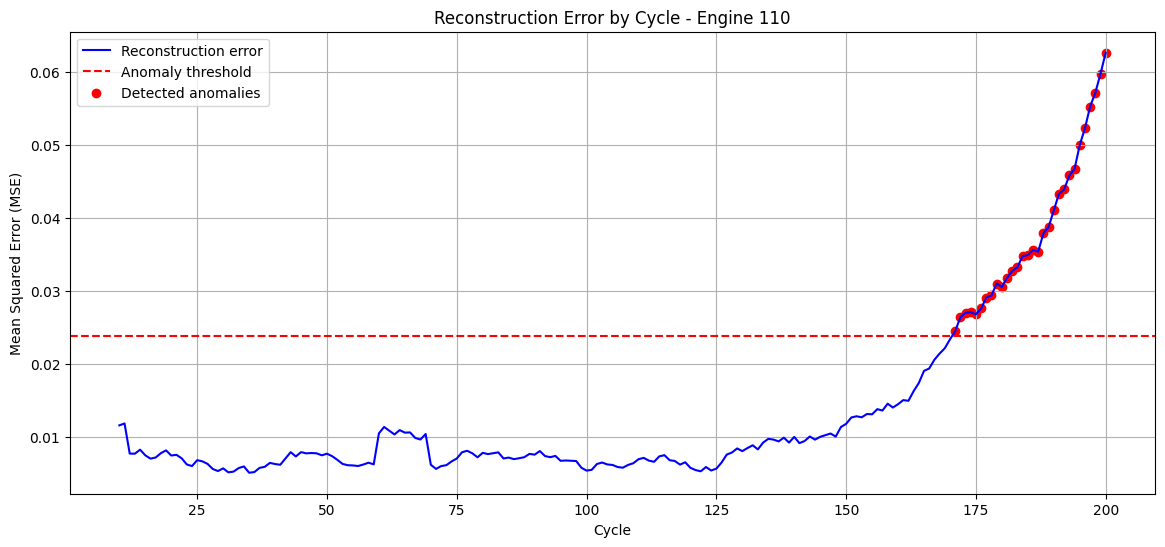

In [11]:
plot_engine_timeseries(110, test_data, model, threshold)

In [12]:
def plot_unified_engine_behavior(engine_id, normal_data, anomaly_data, model, threshold, sequence_length=SEQUENCE_LENGTH):
    """
    Comparatively visualizes normal and anomalous behavior of two engines
    in the same graph, highlighting the transition and exceeding the threshold.
    
    Args:
        engine_id: Engine ID
        normal_data: DataFrame with normal data
        anomaly_data: DataFrame with anomalous data
        model: Trained model
        threshold: Anomaly threshold
        sequence_length: Length of sequences
    """
    plt.figure(figsize=(16, 8))
    
    # Color and style configuration
    NORMAL_COLOR = '#1f77b4'  # Blue
    ANOMALY_COLOR = '#ff7f0e'  # Orange
    THRESHOLD_STYLE = {'color':'red', 'linestyle':'--', 'linewidth':2, 'alpha':0.7}
    FILL_STYLE = {'color':'red', 'alpha':0.1}
    
    # Helper function to process an engine
    def process_engine(engine_id, data, color, label):
        engine_data = data[data['id'] == engine_id].copy()
        features = [f'sensor{i}' for i in range(1, 22)] + ['setting1', 'setting2', 'setting3']
        sequences = []
        engine_values = engine_data[features].values
        
        for i in range(len(engine_values) - sequence_length + 1):
            sequences.append(engine_values[i:i + sequence_length])
        sequences = np.array(sequences)
        
        if len(sequences) > 0:
            predictions = model.predict(sequences, verbose=0)
            min_length = min(predictions.shape[1], sequence_length)
            mse = np.mean(np.power(sequences[:, :min_length, :] - predictions[:, :min_length, :], 2), axis=(1, 2))
            cycles = engine_data['cycle'].values[sequence_length-1:]
            
            # Main plot
            line = plt.plot(cycles, mse, '-', color=color, label=label, linewidth=1.5)
            
            # Highlight anomalies
            anomalies = mse > threshold
            if any(anomalies):
                plt.scatter(cycles[anomalies], mse[anomalies], color='red', s=40, 
                           edgecolors='k', zorder=3, label='Anomalies' if label.startswith('Anomalous') else "")
            
            return cycles, mse
        return None, None
    
    # Process both engines
    normal_cycles, normal_mse = process_engine(engine_id, normal_data, 
                                             NORMAL_COLOR, 'Normal Engine')
    anomaly_cycles, anomaly_mse = process_engine(engine_id, anomaly_data, 
                                               ANOMALY_COLOR, 'Anomalous Engine')
    
    # Threshold and highlighted areas
    plt.axhline(y=threshold, **THRESHOLD_STYLE, label='Anomaly threshold')
    plt.fill_betweenx(y=[threshold, max(plt.ylim()[1], threshold)], 
                     x1=plt.xlim()[0], x2=plt.xlim()[1], **FILL_STYLE)
    
    # Aesthetic adjustments
    plt.title('Comparative Normal vs Anomalous Behavior', pad=20, fontsize=14)
    plt.xlabel('Operation Cycles', labelpad=10)
    plt.ylabel('Reconstruction Error (MSE)', labelpad=10)
    plt.grid(True, alpha=0.3)
    
    # Unified legend without duplicates
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates
    plt.legend(by_label.values(), by_label.keys(), loc='upper left', framealpha=1)
    
    # Explanatory annotation
    plt.annotate('Normal Operation Zone', xy=(0.05, 0.1), xycoords='axes fraction',
                bbox=dict(boxstyle='round', alpha=0.1, color=NORMAL_COLOR))
    plt.annotate('Deterioration Zone', xy=(0.6, 0.8), xycoords='axes fraction',
                bbox=dict(boxstyle='round', alpha=0.1, color=ANOMALY_COLOR))
    
    plt.tight_layout()
    plt.show()

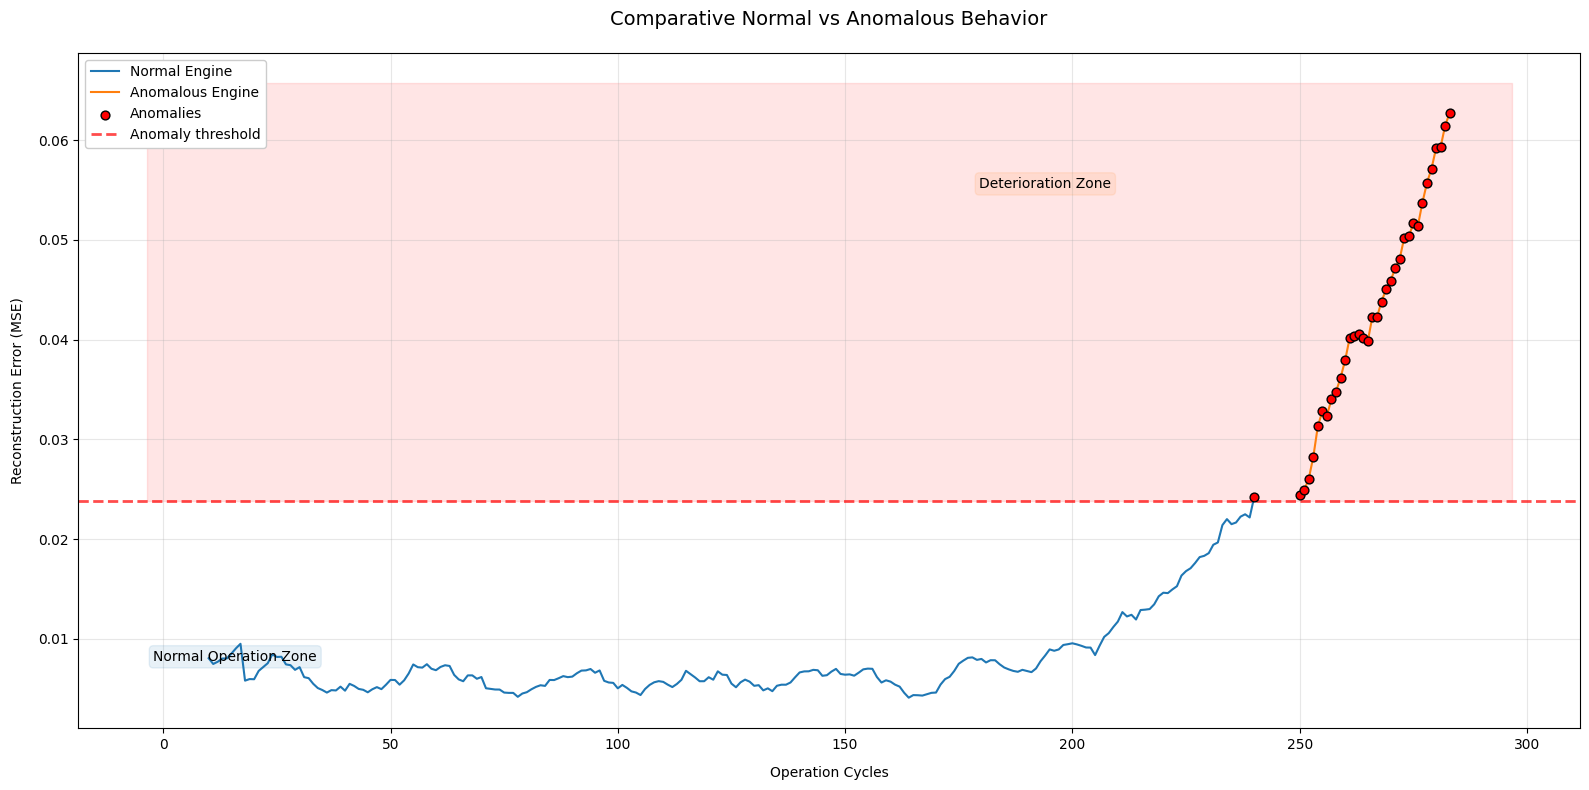

In [15]:
plot_unified_engine_behavior(64, normal_data, anomaly_data, model, threshold)

### Save Models

In [22]:
# Save predicted model
model.save(f'models/pmodel_{MODEL_TYPE}_{DATASET_NUM}.keras')  # or .h5

# Save scaler
with open(f'models/scaler_{DATASET_NUM}.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# save test data for maintenance optimization
test_data.to_csv(f'processed_data/test_data_{DATASET_NUM}.csv', index=False)

# save train data for maintenance optimization
train.to_csv(f'processed_data/train_data_{DATASET_NUM}.csv', index=False)